In [1]:
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat = loadmat('data/S06.mat')
panel = pd.Panel(mat['data'])
''' Item axis: Epoch
    Major axis: Electrode
    Minor axis: Sample '''
FREQ = 250 # Hz
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 769 (items) x 256 (major_axis) x 201 (minor_axis)
Items axis: 0 to 768
Major_axis axis: 0 to 255
Minor_axis axis: 0 to 200

# Extracción de features por sujeto

In [3]:
import gc
gc.collect()

LIMITS = {'delta': (0,4), 'tita': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30, 45)}

def extract_frequency_power(panel):
    mean_samples = panel.mean(1)
    
    def belongs(frequency_range, frequency):
        return frequency_range[0] <= frequency < frequency_range[1]
    
    def compute_welch(series):
        frequencies, power = signal.welch(series, fs=FREQ, nperseg=len(series), nfft=2048)
    
        values_by_range = {'delta':0, 'tita':0, 'alpha':0, 'beta':0, 'gamma':0}
        
        for f, p in zip(frequencies, power):
            for key, limit in LIMITS.items():
                if belongs(limit, f):
                    values_by_range[key] += p
                    break
        return pd.Series(values_by_range)
    
    return mean_samples.apply(compute_welch)  # devuleve un dataframe de Epoch X Bandas

def frequency_features(dataframe, normalize=True, mean=True):
    dataframe = dataframe.copy()
    if normalize:
        for index, band in dataframe.iterrows():
            low_limit, upper_limit = LIMITS[index]
            diff = upper_limit - low_limit
            dataframe.loc[index] = dataframe.loc[index] / diff
    if mean:
        series = dataframe.mean(1)
    else:
        series = dataframe.std(1)
    
    def append_name(i):
        i += '_normalized' if normalize else ''
        i += '_mean' if mean else '_std'
        return i
    
    renamed_series = {append_name(i): series.loc[i] for i in series.index}
    return pd.Series(renamed_series)

In [4]:
import scipy
from collections import defaultdict

ALPHA_RELEVANT_ELECTRODES = [8,44,80,131,185]  # tomamos estos electrodos como representativos del sujeto
                                               # para la intra e inter información

def get_intra(panel):
    def compute_entropy(series):
        histogram, _ = np.histogram(series, 'fd')
        probabilities = [frecuency/len(series) for frecuency in histogram]
        return scipy.stats.entropy(probabilities)

    def compute_entropies_for_subject(panel):
        n_epochs, n_electrodes, n_measures = panel.shape
        entropies = defaultdict(dict)
        for epoch in range(n_epochs):
            for electrode in ALPHA_RELEVANT_ELECTRODES:
                electrode_data = panel[epoch, electrode]
                entropy = compute_entropy(electrode_data)
                entropies[epoch][electrode] = entropy
        return pd.DataFrame(entropies).mean(0)
    
    return compute_entropies_for_subject(panel)

In [5]:
from itertools import combinations

def joint_entropy(signal_1, signal_2):
    _, bins = np.histogram(signal_1.append(signal_2), 'fd')
    
    signal_1 = np.digitize(signal_1, bins)
    signal_2 = np.digitize(signal_2, bins)
    
    signal = list(zip(signal_1, signal_2))
    probabilities = [signal.count(s) / len(signal) for s in signal]
    return scipy.stats.entropy(probabilities)
    

def inter_electrode_analysis(panel, epoch, electrode_1, electrode_2):
    signal_1 = panel[epoch, electrode_1]
    signal_2 = panel[epoch, electrode_2]
    return joint_entropy(signal_1, signal_2)


def joint_entropy_for_subject(panel):
    entropies = defaultdict(list)
    n_epochs, n_electrodes, n_measures = panel.shape
    for epoch in range(n_epochs):
        for combination in combinations(ALPHA_RELEVANT_ELECTRODES, 2):
            entropies[epoch].append(inter_electrode_analysis(panel, epoch, *combination))
    return pd.DataFrame(entropies).mean(0)

In [6]:
import gc
from os import listdir
from os.path import isfile, join

subjects = [f for f in listdir('data') if f.endswith('.mat')]

all_subject_features = {}

for subject_name in subjects:
    print('Processing subject {}'.format(subject_name))
    # panel loading
    panel = pd.Panel(loadmat(join('data', subject_name))['data'])
    
    # FEATURE EXTRACTION
    print('\tIntra entropy')
    intra_entropy = get_intra(panel)
    intra_mean = intra_entropy.mean()
    intra_std = intra_entropy.std()
    
    print('\tInter entropy')
    inter_entropy = joint_entropy_for_subject(panel)
    inter_mean = inter_entropy.mean()
    inter_std = inter_entropy.std()
    
    print('\tBands')
    df = extract_frequency_power(panel)
    mean_normalized = frequency_features(df, normalize=True, mean=True)
    std_normalized = frequency_features(df, normalize=True, mean=False)
    mean_not_normalized = frequency_features(df, normalize=False, mean=True)
    std_not_normalized = frequency_features(df, normalize=False, mean=False)

    print('\tAppending all together')
    subject_features = mean_normalized.append(std_normalized).append(mean_not_normalized).append(std_not_normalized)
    subject_features.loc['type'] = subject_name[0]
    subject_features.loc['intra_mean'] = intra_mean
    subject_features.loc['intra_std'] = intra_std
    subject_features.loc['inter_mean'] = inter_mean
    subject_features.loc['inter_std'] = inter_std
    all_subject_features[subject_name] = subject_features 
    
    # garbage collection
    del panel
    gc.collect()

all_subject_features = pd.DataFrame(all_subject_features)
all_subject_features

Processing subject S02.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject P04.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject P08.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject P03.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject S01.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject S09.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject P05.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject P09.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject S10.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject S07.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject P01.mat
	Intra entropy
	Inter entropy
	Bands
	Appending all together
Processing subject P07.mat
	Intr

,P01.mat,P02.mat,P03.mat,P04.mat,P05.mat,P06.mat,P07.mat,P08.mat,P09.mat,P10.mat,S01.mat,S02.mat,S03.mat,S04.mat,S05.mat,S06.mat,S07.mat,S08.mat,S09.mat,S10.mat
alpha_normalized_mean,9.82905e-15,7.69633e-15,2.43624e-15,1.37319e-15,2.776e-14,5.89524e-16,6.8302e-15,5.59793e-15,3.86489e-13,1.79013e-16,8.53576e-16,4.64487e-15,4.42539e-15,1.53395e-14,1.84321e-16,2.31353e-15,3.34592e-14,2.23208e-14,1.13987e-11,6.74658e-15
beta_normalized_mean,7.14798e-15,2.46493e-15,5.3657e-16,1.4113e-16,2.99943e-14,1.18589e-16,4.12468e-15,1.35959e-15,3.09289e-13,5.02423e-17,2.8888e-16,1.63189e-16,3.74003e-16,2.58775e-15,3.72254e-17,2.56303e-16,2.32068e-15,6.78551e-15,3.19229e-12,4.33699e-15
delta_normalized_mean,1.61566e-13,4.43176e-13,1.19822e-13,1.94471e-14,5.56367e-13,1.11826e-14,2.08559e-13,2.28108e-13,6.96034e-12,2.24136e-15,4.69568e-15,1.6132e-15,4.76178e-15,3.51835e-14,9.8557e-16,1.65248e-15,8.96041e-14,2.60795e-14,2.79846e-11,3.4361e-14
gamma_normalized_mean,7.18942e-15,1.91463e-15,3.65112e-16,5.27349e-17,2.70326e-14,2.88102e-17,2.69171e-15,6.95342e-16,2.57643e-13,2.78152e-17,1.26607e-16,2.43644e-17,7.46198e-17,1.30545e-15,8.28967e-18,9.09459e-17,1.04279e-15,7.29298e-15,4.4563e-13,3.79439e-15
tita_normalized_mean,2.75136e-14,1.09571e-13,8.90023e-15,7.46959e-15,8.20232e-14,1.44998e-15,4.0122e-14,4.81253e-14,1.62815e-12,7.23722e-16,9.7733e-16,7.76565e-16,2.37025e-15,9.98331e-15,3.75921e-16,9.41873e-16,9.00727e-15,1.08507e-14,1.62324e-11,8.24463e-15
alpha_normalized_std,8.60128e-15,7.2457e-15,1.80787e-15,1.32245e-15,1.8377e-14,5.44518e-16,5.56408e-15,6.26223e-15,4.58829e-13,1.64524e-16,7.86243e-16,3.17058e-15,3.81297e-15,1.19276e-14,1.77606e-16,3.17662e-15,2.31029e-14,1.9772e-14,1.13933e-11,7.13585e-15
beta_normalized_std,1.03684e-14,1.99556e-15,4.01901e-16,1.17782e-16,2.0051e-14,1.60934e-16,2.87884e-15,1.61443e-15,2.15935e-13,8.7828e-17,1.78414e-16,8.23386e-17,1.96704e-16,2.43711e-15,2.14984e-17,2.51385e-16,1.06689e-15,3.24439e-15,3.31319e-12,1.11512e-14
delta_normalized_std,2.10699e-13,3.90343e-13,1.30563e-13,2.51407e-14,5.56493e-13,2.08927e-14,1.98083e-13,3.62456e-13,1.25347e-11,2.16383e-15,5.16645e-15,3.04042e-15,7.22387e-15,5.52985e-14,1.76529e-15,2.23607e-15,1.14637e-13,2.55747e-14,6.57272e-11,4.74511e-14
gamma_normalized_std,1.5756e-14,2.12443e-15,3.24999e-16,6.82629e-17,2.24701e-14,3.95619e-17,2.57526e-15,1.29111e-15,2.11004e-13,7.90667e-17,7.8273e-17,1.30546e-17,1.10004e-16,1.98916e-15,4.77658e-18,1.54835e-16,6.5553e-16,4.88309e-15,2.69951e-13,1.4654e-14
tita_normalized_std,2.71249e-14,1.10541e-13,6.84991e-15,6.3969e-15,5.99923e-14,2.08402e-15,3.76217e-14,6.53149e-14,2.30139e-12,5.90427e-16,7.57835e-16,6.77989e-16,2.16544e-15,7.92229e-15,5.65959e-16,8.26603e-16,8.7815e-15,8.31575e-15,1.70058e-11,8.93105e-15


In [7]:
all_subject_features.to_csv('features.csv')

In [8]:
features = pd.read_csv('features.csv')

In [9]:
features

,Unnamed: 0,P01.mat,P02.mat,P03.mat,P04.mat,P05.mat,P06.mat,P07.mat,P08.mat,P09.mat,...,S01.mat,S02.mat,S03.mat,S04.mat,S05.mat,S06.mat,S07.mat,S08.mat,S09.mat,S10.mat
0,alpha_normalized_mean,9.829053847830551e-15,7.69633127041401e-15,2.4362372297067118e-15,1.3731907856624355e-15,2.776001496741752e-14,5.895241894226954e-16,6.83019524790237e-15,5.597927848037407e-15,3.86488969652696e-13,...,8.53576200603959e-16,4.644873208170374e-15,4.425392833332027e-15,1.5339507028293908e-14,1.8432139096020813e-16,2.313533739846514e-15,3.345915605848949e-14,2.232078109245602e-14,1.139873698657016e-11,6.746581530663677e-15
1,beta_normalized_mean,7.147977373890572e-15,2.464934752915817e-15,5.365700258641962e-16,1.4112990837578056e-16,2.9994340517226865e-14,1.1858934303401494e-16,4.124676091946023e-15,1.3595877897423968e-15,3.0928888450936374e-13,...,2.888796239621006e-16,1.6318858745141307e-16,3.740028616171097e-16,2.5877450747898656e-15,3.7225421539859336e-17,2.563031520413821e-16,2.3206824205368802e-15,6.785506158047248e-15,3.1922872323667037e-12,4.336991754541947e-15
2,delta_normalized_mean,1.6156644126779668e-13,4.4317628606370423e-13,1.1982182418212348e-13,1.944707853831348e-14,5.563665967206757e-13,1.1182559289819232e-14,2.0855899206813257e-13,2.2810782026715297e-13,6.9603407905600604e-12,...,4.695675495431233e-15,1.6132026775088405e-15,4.761784766865129e-15,3.518346396173234e-14,9.855701412579982e-16,1.6524811405990501e-15,8.960410135368391e-14,2.6079496944368876e-14,2.798459985182664e-11,3.436100164701306e-14
3,gamma_normalized_mean,7.189416456658522e-15,1.9146328160292335e-15,3.6511233545226446e-16,5.273494657515757e-17,2.7032617550787046e-14,2.8810176115504003e-17,2.691710374438815e-15,6.953423581517185e-16,2.5764258571360535e-13,...,1.2660673104137262e-16,2.4364392552654886e-17,7.46198416362411e-17,1.3054508053452949e-15,8.289666444624726e-18,9.094588494831026e-17,1.0427923558505925e-15,7.292984911404782e-15,4.4563049164503034e-13,3.794389919437959e-15
4,tita_normalized_mean,2.75136065069365e-14,1.0957086156536728e-13,8.900232349044733e-15,7.469585402176875e-15,8.202318780725955e-14,1.4499764501416197e-15,4.0122020104564775e-14,4.812527414368219e-14,1.6281494582268033e-12,...,9.773297568422329e-16,7.765649558480512e-16,2.3702455805499846e-15,9.983314940041114e-15,3.7592076347606723e-16,9.41873058874074e-16,9.007273892454745e-15,1.085068078468738e-14,1.6232400177539395e-11,8.244627697457384e-15
5,alpha_normalized_std,8.601276434418848e-15,7.245699147947255e-15,1.8078683059022063e-15,1.3224458816873754e-15,1.837704878579111e-14,5.445181456897278e-16,5.564076904192932e-15,6.262231537381675e-15,4.588289957917434e-13,...,7.862430490439794e-16,3.170575832351916e-15,3.812965010917879e-15,1.1927646777177712e-14,1.7760581582287477e-16,3.176615129830901e-15,2.3102881135904533e-14,1.9771953253364783e-14,1.1393290592639891e-11,7.135851263830304e-15
6,beta_normalized_std,1.036840889069924e-14,1.9955567087453367e-15,4.019013807353245e-16,1.1778161796872667e-16,2.0051024638923415e-14,1.609343064620575e-16,2.878844324365554e-15,1.6144300707860118e-15,2.1593537813116674e-13,...,1.7841435915567483e-16,8.233855120377301e-17,1.9670437402721124e-16,2.4371147746315237e-15,2.1498368553608417e-17,2.513845076145465e-16,1.0668886236922182e-15,3.244385038271939e-15,3.3131917456536854e-12,1.1151181265020718e-14
7,delta_normalized_std,2.1069882429203167e-13,3.9034341145549554e-13,1.305634933560283e-13,2.5140676114023005e-14,5.56492892123931e-13,2.0892658057260868e-14,1.9808298540653745e-13,3.6245645775902263e-13,1.2534650361479603e-11,...,5.166451208811936e-15,3.040417290972725e-15,7.223870353797995e-15,5.5298493053444116e-14,1.7652895044253115e-15,2.2360738004028407e-15,1.1463671497549434e-13,2.5574679997988977e-14,6.57272378804269e-11,4.74510699291744e-14
8,gamma_normalized_std,1.575600314316059e-14,2.1244340461690774e-15,3.2499943708647414e-16,6.826292949770192e-17,2.2470100376411796e-14,3.9561942570951053e-17,2.57525832679948e-15,1.291105428953603e-15,2.1100

## Curva ROC

alpha_mean : 0.54


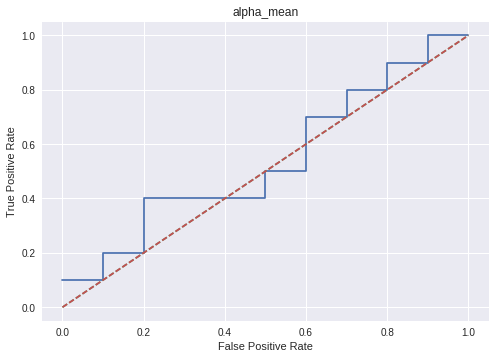

beta_mean : 0.53


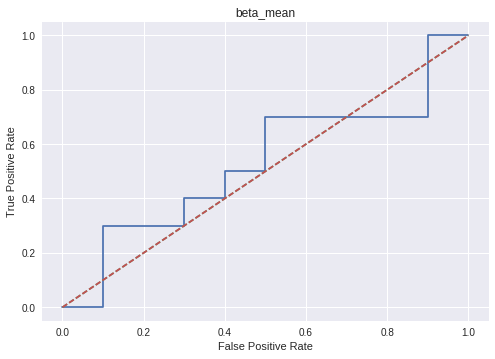

delta_mean : 0.76


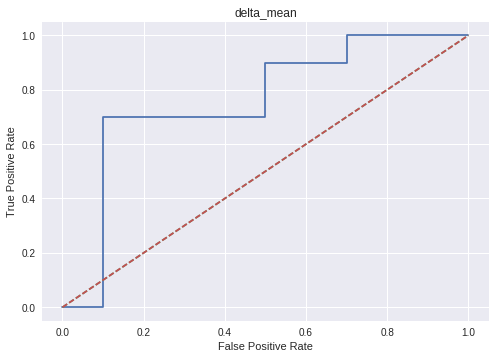

gamma_mean : 0.56


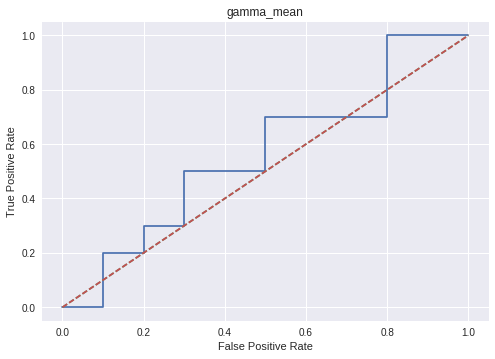

tita_mean : 0.7


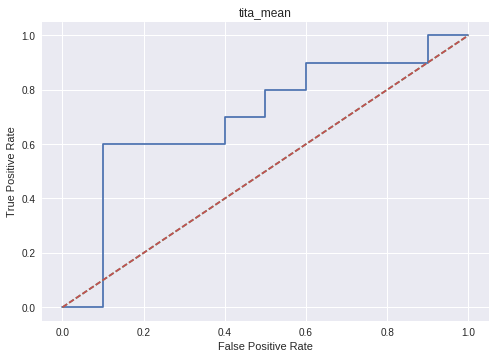

alpha_std : 0.57


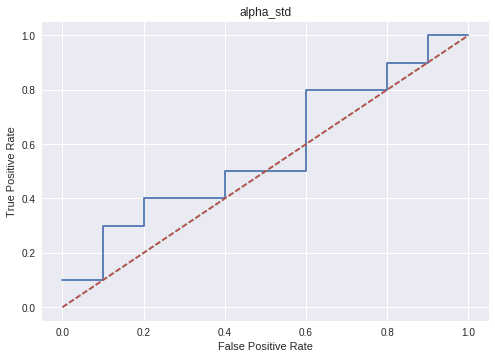

beta_std : 0.56


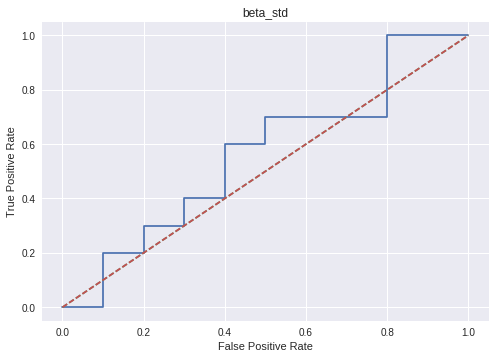

delta_std : 0.74


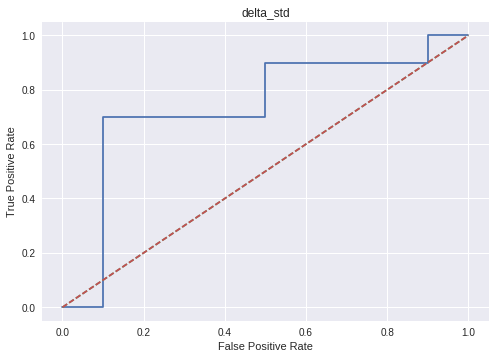

gamma_std : 0.59


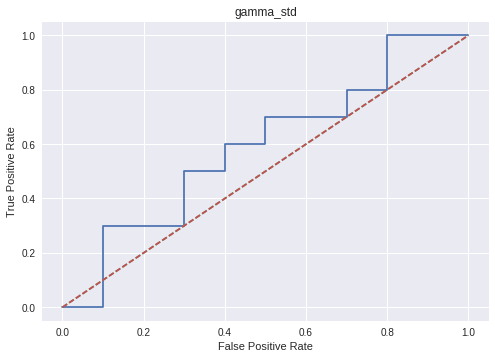

tita_std : 0.69


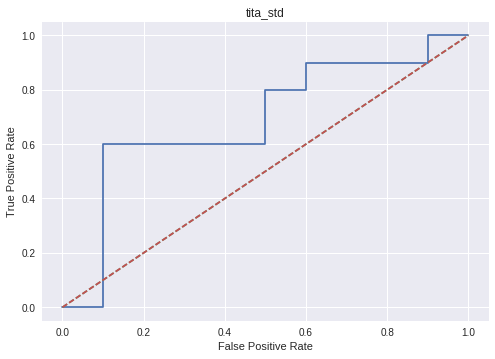

intra_mean : 1.0


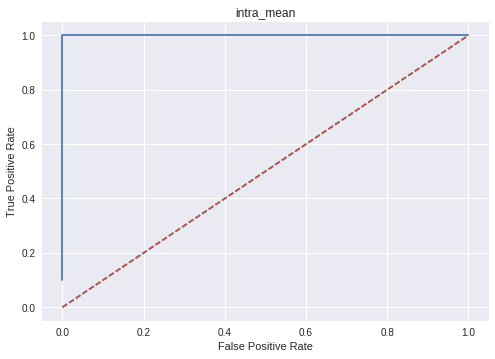

intra_std : 0.97


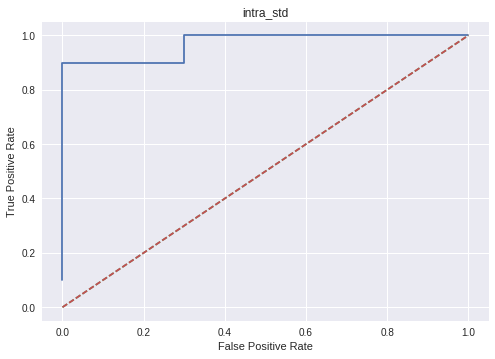

inter_mean : 0.69


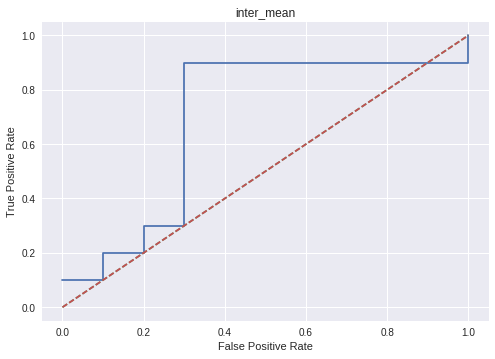

inter_std : 0.7


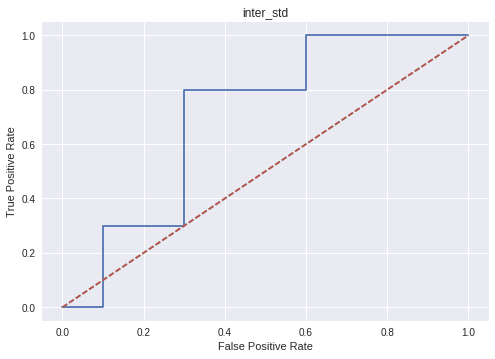

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dataset = pd.read_csv('features.csv')

y = dataset.loc[20][1:].values
y_binary = [1 if v == 'P' else 0 for v in y]
y_binary_reversed = [0 if v == 'P' else 1 for v in y]

for i, row in dataset.iterrows():
    if i == 20:
        continue # skip labels
    feature = row[0]
    if 'normalized' in feature:
        continue # skip normalized as they are equal in roc performance
    
    x = row[1:].values
    x = x.astype('float')

    fpr, tpr, thresholds = roc_curve(y_binary, x)
    auc = roc_auc_score(y_binary, x)
    if (auc < 0.5):
        fpr, tpr, thresholds = roc_curve(y_binary_reversed, x)
        auc = roc_auc_score(y_binary_reversed, x)
    
    plt.plot(fpr, tpr)
    plt.title(feature)
    plt.plot(((0,0),(1,1)), '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(feature, ':', auc)
    plt.show()
    
    

# Logistic Regression

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

dataset = pd.read_csv('features.csv')

y = dataset.loc[20][1:].values
y_binary = [1 if v == 'P' else 0 for v in y]
y_binary_reversed = [0 if v == 'P' else 1 for v in y]
auc_for_feature = {}

for i, row in dataset.iterrows():
    if i == 20:
        continue # skip labels
    feature = row[0]
    
    x = row[1:].values
    x = x.astype('float')
    
    aucs = []
    for _ in range(500):
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        x_train = np.reshape(x_train, (x_train.shape[0], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], 1))
        y_train_binary = [1 if v == 'P' else 0 for v in y_train]
        x_train /= x_train.min()   # scaling

        clf = LogisticRegression()
        clf.fit(x_train, y_train)
        
        score = clf.predict_proba(x_train)[:,0]
        aucs.append(roc_auc_score(y_train_binary, score))
    auc_for_feature[feature] = np.mean(aucs)
auc_for_feature

{'alpha_mean': 0.54691788359788374,
 'alpha_normalized_mean': 0.54949603174603179,
 'alpha_normalized_std': 0.56399656084656091,
 'alpha_std': 0.5727591534391534,
 'beta_mean': 0.5160095767195767,
 'beta_normalized_mean': 0.51315211640211644,
 'beta_normalized_std': 0.50108079365079361,
 'beta_std': 0.50154687830687827,
 'delta_mean': 0.40968788359788361,
 'delta_normalized_mean': 0.42808259259259263,
 'delta_normalized_std': 0.42014037037037039,
 'delta_std': 0.4080111111111111,
 'gamma_mean': 0.50695312169312168,
 'gamma_normalized_mean': 0.50626793650793644,
 'gamma_normalized_std': 0.51553835978835971,
 'gamma_std': 0.51823534391534398,
 'inter_mean': 0.49301804232804236,
 'inter_std': 0.69675079365079362,
 'intra_mean': 0.86599999999999999,
 'intra_std': 0.9701735978835978,
 'tita_mean': 0.44244423280423278,
 'tita_normalized_mean': 0.45823296296296295,
 'tita_normalized_std': 0.43638783068783071,
 'tita_std': 0.44715455026455025}

# Análisis Multivariado

AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0
AUC: 0.0


/home/alpamayo/.local/lib/python3.5/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


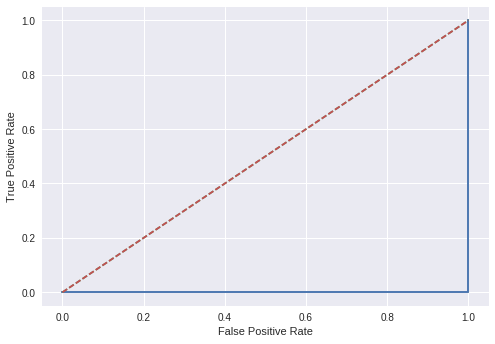

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

dataset = pd.read_csv('features.csv')

y = dataset.loc[20][1:].values
y_binary = [1 if v == 'P' else 0 for v in y]
dataset = dataset.drop(20).drop(dataset.columns[[0]], axis=1).T

clf = svm.SVC()
clf.fit(dataset, y)

for _ in range(20):
    x_train, x_test, y_train, y_test = train_test_split(dataset, y)
    y_test_binary = [1 if v == 'P' else 0 for v in y_test]
    
    clf = svm.SVC(probability=True)
    clf.fit(x_train, y_train)

    scores = clf.predict_proba(x_test)[:,0]
    fpr, tpr, thresholds = roc_curve(y_test_binary, scores)

    try:
        auc = roc_auc_score(y_test_binary, scores)
    except ValueError:
        # may fail if only one label in test set
        continue

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print('AUC:', auc)
plt.plot(((0,0),(1,1)), '--')
plt.show()

AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 0.666666666667
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0


/home/alpamayo/.local/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/alpamayo/.local/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0


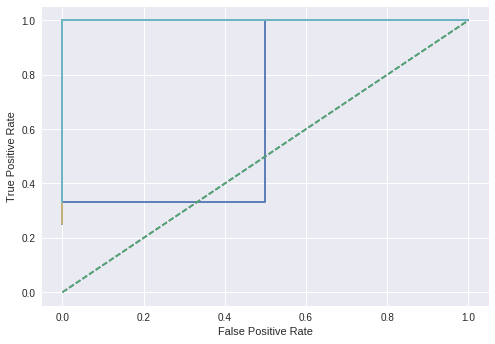

In [13]:
import pandas as pd
from sklearn import svm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('features.csv')

y = dataset.loc[20][1:].values
y_binary = [1 if v == 'P' else 0 for v in y]
dataset = dataset.drop(20).drop(dataset.columns[[0]], axis=1).T

clf = Pipeline([
  ('scaler', StandardScaler()),
  ('feature_selection', SelectPercentile(percentile=10)),
  ('classification', svm.SVC(probability=True))
])

for _ in range(20):
    x_train, x_test, y_train, y_test = train_test_split(dataset, y)
    y_test_binary = [1 if v == 'P' else 0 for v in y_test]
    
    clf.fit(x_train, y_train)

    scores = clf.predict_proba(x_test)[:,0]
    fpr, tpr, thresholds = roc_curve(y_test_binary, scores)

    try:
        auc = roc_auc_score(y_test_binary, scores)
    except ValueError:
        # may fail if only one label in test set
        continue

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print('AUC:', auc)
plt.plot(((0,0),(1,1)), '--')
plt.show()